In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.signal
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
obs_rate = 100

f_obs = 8089.5e6

def load_file(filename, date):
    phase = np.fromfile(filename, dtype = 'float32').astype('double')
    start = np.datetime64(date)
    timestamps = start + np.timedelta64(1, 'ns') * np.arange(phase.shape[0]) * 1e9 / obs_rate
    return xr.Dataset({'phase' : ('time', np.unwrap(phase))}, coords = {'time' : timestamps})

In [3]:
data = load_file('phase_bpsk_bochum.f32', '2019-11-24T22:45:50.003').sel(time = slice('2019-11-24T22:46', '2019-11-25'))

In [4]:
(data.coords['time'][-1] - data.coords['time'][0]).astype('float') * 1e-9

<xarray.DataArray 'time' ()>
array(946.3)

In [5]:
def remove_quadratic(data):
    t = (data.coords['time']-data.coords['time'][0]).astype('float')*1e-9
    pf = np.polyfit(t, data['phase'], 2)
    return xr.Dataset({'phase' : data['phase'] - np.array(np.polyval(pf, t))},
                      coords = data.coords), pf

In [6]:
data_removed, p = remove_quadratic(data)
p[0]/(2*np.pi*f_obs)

4.526183888845259e-14

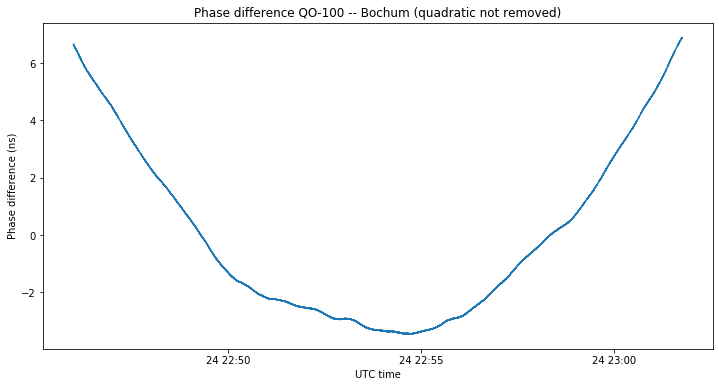

In [7]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(data.coords['time'], scipy.signal.detrend(data['phase']*1e9/(2*np.pi*f_obs)))
plt.title('Phase difference QO-100 -- Bochum (quadratic not removed)')
plt.ylabel('Phase difference (ns)')
plt.xlabel('UTC time');

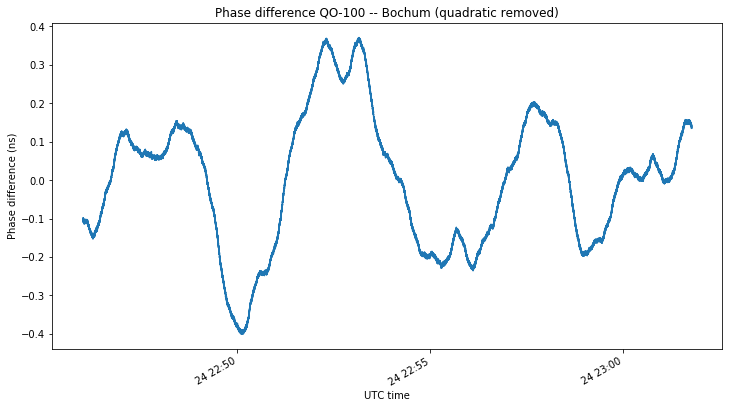

In [8]:
plt.figure(figsize = (12,6), facecolor = 'w')
(data_removed['phase']*1e9/(2*np.pi*f_obs)).plot()
plt.title('Phase difference QO-100 -- Bochum (quadratic removed)')
plt.ylabel('Phase difference (ns)')
plt.xlabel('UTC time');

In [9]:
def adev(series, skip, freq = 10e9, overlapping = False):
    x = series.values/(2*np.pi*freq)
    
    tau = skip / obs_rate
    if overlapping:
        y = x[:-2*skip] - 2*x[skip:-skip] + x[2*skip:]
    else:
        z = x[:x.size//skip*skip].reshape((-1,skip))[:,0]
        y = z[:-2] - 2*z[1:-1] + z[2:]
    return np.sqrt(0.5/tau**2*np.average(y**2))

def get_skips(n):
    if n <= 0:
        return np.array([], dtype = 'int')
    a = int(np.log10(n))
    step = max(10**(a-2), 1)
    return np.concatenate((get_skips(10**a - 1) , np.arange(10**a, n+1, step)))

def compute_adev(data, overlapping = False):
    skips = get_skips(data.coords['time'].size//2)
    taus = skips / obs_rate
    adevs = [adev(data['phase'], skip, f_obs, overlapping) for skip in skips]
    return xr.Dataset({'adev' : ('tau', adevs)}, coords = {'tau' : taus})

Recompute Allan deviations (takes several minutes)

In [10]:
adevs = compute_adev(data, overlapping = True)
adevs_removed = compute_adev(data_removed, overlapping = True)

In [11]:
def plot_adev(a, label):
    plt.loglog(a.coords['tau'], a['adev'], label = f'{label}')

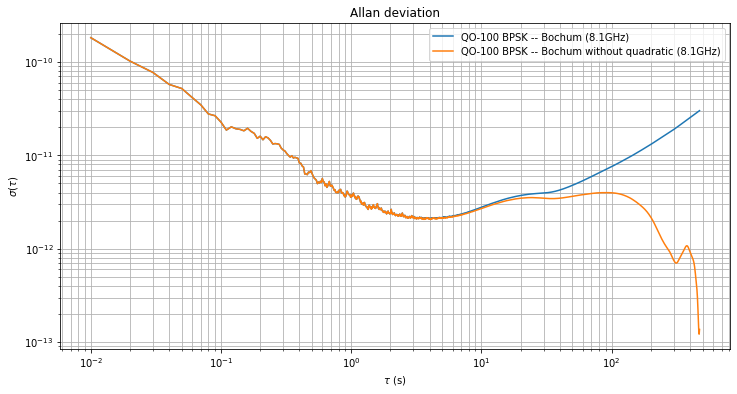

In [12]:
plt.figure(figsize = (12,6), facecolor = 'w')
plot_adev(adevs, 'QO-100 BPSK -- Bochum (8.1GHz)')
plot_adev(adevs_removed, 'QO-100 BPSK -- Bochum without quadratic (8.1GHz)')
plt.xlabel('$\\tau$ (s)')
plt.ylabel('$\\sigma(\\tau)$')
plt.legend()
plt.grid(which = 'both')
plt.title('Allan deviation');